## Linear Regression Model
The block of codes below utilize Linear Regression Model as implemented in Scikit-learn to predict eigen values 
of HSE06 quality using the elementwise-orbital contribution of the atoms to the corresponding eigenstates in 
PBE calculations.
### Note:
We will require two .tar.gz files for running this notebook namely, special_concatenations_compounds_atom_sum.tar.gz 
and atom_sum_compound_csv_files.tar.gz. These are explicitly present here on the GitHub. For backup,
you could also access these tarballs from dropbox (dropbox/ML_eigenshift) or 
from the Hyperion cluster (/work/sutton-lab/ml_eigenshift/krr/concatenated/modified_pettifor).

## Importing modules:
We will require following modules for using the linear model. Don't forget to use eg. pip install numpy and so on
to install the missing modules.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import pylab as pl
import ase
from ase.io import read, write
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import tarfile

/home/santosh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/santosh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=

## Atom-based feature
We define here atom-based feature namely modified pettifor scale (Glawe et al 2016 New J. Phys. 18 093011). This
is based on similarity index and gives a measure of replaceability of an element in a compound so that the crystal
symmetry remains unchanged. Although the scale is unique for each elements, we construct compositional based value
to represent a compound.

In [2]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

def string_number_separator(string):
    import re
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    res = temp.match(string).groups()
    return res

def list_of_atoms_and_numbers(string):
    atoms=[]
    atoms_number=[]
    str1=''
    while len(str1)<len(string):
        string1=str(string)[len(str1):]
        x,y=string_number_separator(string1)
        str1=str1+str(x)+str(y)
        atoms.append(str(x))
        atoms_number.append(int(y))
    return atoms, atoms_number

def modified_pettifor(in_atom):

    mod_scale = {
                "He": 1,
                "Ne": 2,
                "Ar": 3,
                "Kr": 4,
                "Xe": 5,
                "Rn": 6,
                "Fr": 7,
                "Cs": 8,
                "Rb": 9,
                "K": 10,
                "Na": 11,
                "Li": 12,
                "Ra": 13,
                "Ba": 14,
                "Sr": 15,
                "Ca": 16,
                "Eu": 17,
                "Yb": 18,
                "Lu": 19,
                "Tm": 20,
                "Y": 21,
                "Er": 22,
                "Ho": 23,
                "Dy": 24,
                "Tb": 25,
                "Gd": 26,
                "Sm": 27,
                "Pm": 28,
                "Nd": 29,
                "Pr": 30,
                "Ce": 31,
                "La": 32,
                "Ac": 33,
                "Th": 34,
                "Pa": 35,
                "U": 36,
                "Np": 37,
                "Pu": 38,
                "Am": 39,
                "Cm": 40,
                "Bk": 41,
                "Cf": 42,
                "Es": 43,
                "Fm": 44,
                "Md": 45,
                "No": 46,
                "Lr": 47,
                "Sc": 48,
                "Zr": 49,
                "Hf": 50,
                "Ti": 51,
                "Ta": 52,
                "Nb": 53,
                "V": 54,
                "Cr": 55,
                "Mo": 56,
                "W": 57,
                "Re": 58,
                "Tc": 59,
                "Os": 60,
                "Ru": 61,
                "Ir": 62,
                "Rh": 63,
                "Pt": 64,
                "Pd": 65,
                "Au": 66,
                "Ag": 67,
                "Cu": 68,
                "Ni": 69,
                "Co": 70,
                "Fe": 71,
                "Mn": 72,
                "Mg": 73,
                "Zn": 74,
                "Cd": 75,
                "Hg": 76,
                "Be": 77,
                "Al": 78,
                "Ga": 79,
                "In": 80,
                "Tl": 81,
                "Pb": 82,
                "Sn": 83,
                "Ge": 84,
                "Si": 85,
                "B": 86,
                "C": 87,
                "N": 88,
                "P": 89,
                "As": 90,
                "Sb": 91,
                "Bi": 92,
                "Po": 93,
                "Te": 94,
                "Se": 95,
                "S": 96,
                "O": 97,
                "At": 98,
                "I": 99,
                "Br": 100,
                "Cl": 101,
                "F": 102,
                "H": 103
            }

    return mod_scale[in_atom]/float(max(mod_scale.values()))

def compound_pettifor(compound):
    cpd=compound.split('-')[0]
    in_atom,num_atom=list_of_atoms_and_numbers(cpd)
    if len(in_atom)==1:
        norm_pettifor=modified_pettifor(in_atom[0])
        return norm_pettifor
    else:
        norm_pettifor=0
        for i in range (len(in_atom)):
            tot=sum(num_atom)
            norm_pettifor+=(num_atom[i]/tot)*modified_pettifor(in_atom[i])
        return norm_pettifor


We are defining three functions below. Please also see the comments above each functions for more details. 
First couple of functions namely 'two_csv_train_test', and 'single_csv_train_test' prepare the numpy arrays
necessary for training and testing the linear regression model. The last function named 'plot' is to get the
scatter plots using the outputs of the first two functions.

In [3]:
# Functions two_csv_train_test takes 2 arguments. First is the path of csv file used for training while the
# second is the path of csv for testing. The default input columns are [1s,2s,.....,6p,PBE_EF]
#It returns four numpy arrays in following order: 1. train_input 2. test_input 3. train_target 4. test_target. 
# Note these in order are the arguments for function plot

def two_csv_train_test(path_csv_train,path_csv_test):
    train_csv_to_df=pd.read_csv(path_csv_train) # eg. concat_dir+'Ca1O1.csv'
    #train_csv_to_df['pet'] = [ compound_pettifor(compound) for compound in train_csv_to_df['compound'] ]
    columns_input=['pet','ACT_PBE','PD_PBE','bg_PBE','bg_HSE'] 
    keep_cols=columns_input
    train_data_inp=train_csv_to_df[keep_cols].to_numpy()[:, :-1]
    train_input_feature=train_csv_to_df[keep_cols].to_numpy()[:, :-1]
    train_target_feature=train_csv_to_df[keep_cols].to_numpy()[:, -1].reshape(-1, 1)
    #print(train_input_feature)
    #print(train_target_feature)
    test_csv_to_df=pd.read_csv(path_csv_test) # eg. concat_dir+'Ca1O1.csv'
    test_csv_to_df['pet'] = [ compound_pettifor(compound) for compound in test_csv_to_df['compound'] ]    
    test_data_inp=test_csv_to_df[keep_cols].to_numpy()[:, :-1]
    test_input_feature=test_csv_to_df[keep_cols].to_numpy()[:, :-1]
    test_target_feature=test_csv_to_df[keep_cols].to_numpy()[:, -1].reshape(-1, 1)
    print(np.shape(train_input_feature),np.shape(train_target_feature))
    return train_input_feature,test_input_feature,train_target_feature,test_target_feature

# Functions single_csv_train_test takes 2 arguments. First is the path of the csv file used for both training and 
# testing. Second is the compress fraction of how much data to use from original (Recommended: use 1 for single
# system (0.3-0.6) for specific concatenations. Use 0.1 for whole concatenated dataset). Note default split is 80/20
# . Make sure you adjust it inside the function to change it. It returns four numpy arrays in following order: 
# train_input, test_input, train_target, test_target. Note these in order are the arguments for function plot

def single_csv_train_test(path_csv_file,compress_fraction): 
    split_frac=0.8
    ag2o_csv_to_df=pd.read_csv(path_csv_file) #eg. all_files_dir+'Ag2O1.csv'
    columns_input=['pet','ACT_PBE','PD_PBE','bg_PBE','bg_HSE']
    keep_cols=columns_input
    ag2o_input_feature=ag2o_csv_to_df[keep_cols].to_numpy()
    random_indices=ag2o_input_feature[np.random.randint(ag2o_input_feature.shape[0], size=int(compress_fraction*ag2o_input_feature.shape[0])), :]
    siz_x,siz_yy=np.shape(random_indices)
    split=int(siz_x*split_frac)
    array1= random_indices[:split,:] # indexing/selection of the 80%
    array2 = random_indices[split:,:]
    print(np.shape(array1),np.shape(array2))
    return array1[:, :-1],array2[:, :-1],array1[:,-1].reshape(-1,1),array2[:,-1].reshape(-1,1)



# As suggested above function plot is used for generating scatter plot it takes four numpy arrays in following order as
# input: 1. train_input 2. test_input 3. train_target 4. test_target . It returns plot as plt, train_mae, and test_mae
# We can save, display the plot obtained from here. do not forget to close the plot after calling it. eg. plt.close()

def plot(x,p,y,q):
    clf=linear_model.LinearRegression()
    y2=clf.fit(x,y)
    y_hat2=clf.predict(x)
    q_hat2=clf.predict(p)
    train_mae=mean_absolute_error(y,y_hat2)
    test_mae=mean_absolute_error(q,q_hat2)
    #print(train_mae,test_mae)
    a=np.min(y)
    b=np.max(y)
    #print(a,b)
    diag_array=np.linspace(a, b, num=1000)
    aspect_ratio=(6,5)
    left_margin=0.2 # Adjust it for your best results
    fig= plt.figure(figsize=aspect_ratio)
    mpl.rcParams['axes.linewidth']=1.5
    #plt.ylim(band_min,band_max)
    #plt.xlim(xmin,xmax)
    plt.scatter(diag_array,diag_array,s=0.5,color='black',alpha=1.0)
    plt.scatter(y,y_hat2,color='grey',s=40,marker='o',label='train')
    plt.scatter(q,q_hat2,color='blue',s=40,marker='^',label='test')
    plt.xlabel("HSE band gap(in eV)",fontsize=16)
    plt.ylabel("ML band gap (eV)",fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True)
    #plt.axhline(y=0.0,color='purple',linestyle='--',linewidth=1.5)
    plt.subplots_adjust(left=left_margin)
    plt.legend(fontsize='14',ncol=1, loc='lower right',frameon=False)

    #plt.savefig('_train='+str(train_mae)+'_test'+str(test_mae)+'.pdf',dpi=80)
    #plt.show()
    return plt,train_mae,test_mae

We here provide the location of the csv files. These csv files provide the information of mostly PBE calculations.
It displays sum of elementwise-orbital contribution to eigen states along with the eigenvalues, shift of eigenvalue
wrt the fermi level, corresponding eigen values and shift from HSE06 calculations and finally the shift between PBE and
HSE06 eigenvalues at each eigenstates. The csv files corresponding to each compound are found in the folder 
atom_sum_compound_csv_files or its corresponding tarball. The folder special_concatenations_compounds_atom_sum or 
its corresponding tarball consists of the concatenation of various files mostly intuitive by their name.
You can also look for dropbox or Hyperion cluster to access them as detailed in first block above.

The block below utilizes functions defined above to show/save the plot. Don't forget to use plt.savefig("name.pdf",dpi=80)
to save the figure.

(13, 5) (4, 5)
0.22698373228831267 0.5971314482330091


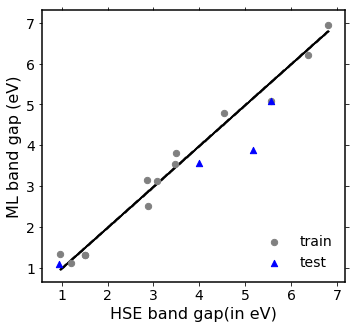

In [25]:
'''
x,p,y,q=single_csv_train_test(all_files_dir+'Ag2O1.csv',1.0)
plt,train_mae,test_mae=plot(x,p,y,q)
print(train_mae,test_mae)
#plt.savefig('linear_regression_Ag2O1.pdf',dpi=80)
plt.show()
plt.close()

x,p,y,q=two_csv_train_test(concat_dir+'Ca1O1.csv',all_files_dir+'Ag2O1.csv')
plt,train_mae,test_mae=plot(x,p,y,q)
print(train_mae,test_mae)
plt.show()
plt.close()
'''
x,p,y,q=single_csv_train_test('properties.csv',0.2)
plt,train_mae,test_mae=plot(x,p,y,q)
print(train_mae,test_mae)
plt.savefig('concat_ten_percent_linear.pdf',dpi=80)
plt.show()
plt.close()
pass